In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from keras import backend as K
from glob import glob
import cv2
import random
from numpy.random import seed
from keras.layers import Lambda

from google.colab.patches import cv2_imshow

In [ ]:
seed(1)

In [ ]:
def buildFusionNetwork(tensor, channels = 64, kernel_size = 3):
  init = tensor
  filter = 5 * channels
  conv = keras.layers.Conv2D(filters = filter, kernel_size=kernel_size, padding = 'same', activation=None)(init)

  se = keras.layers.GlobalAveragePooling2D()(conv)
  se = keras.layers.Reshape((1, 1, filter))(se)
  se = keras.layers.Dense(((filter) // 16), activation = 'sigmoid', kernel_initializer='he_normal')(se)
  se = keras.layers.Dense((filter), activation = 'sigmoid', kernel_initializer='he_normal')(se)

  x = keras.layers.multiply([init, se])

  conv1 = keras.layers.Conv2D(filters = 128, kernel_size = kernel_size, padding = 'same', activation = 'relu')(x)
  # conv1 = keras.layers.Conv2D(filters = 128, kernel_size = kernel_size, padding = 'same', activation = 'relu')(conv1)
  conv2 = keras.layers.Conv2D(filters = channels, kernel_size=1, padding = 'same', activation = 'relu')(conv1)

  return conv2

In [ ]:
def darken(image, k, m = 2, alpha = 6):
  result = (((alpha) ** (abs(k) / m)) * (image - 1)) + 1
  result = tf.clip_by_value(result, 0, 1)
  return result

In [ ]:
def brighten(image, k, m = 2, alpha = 6):
  result = ((alpha) ** (k / m)) * image
  result = tf.clip_by_value(result, 0, 1)
  return result

In [ ]:
def buildNetwork(input_shape, channels = 64, kernel_size = 3):
  input = keras.Input(shape = input_shape, name = 'Input Layer')

  input1 = Lambda(darken, arguments = {'k':-2})(input)
  input2 = Lambda(darken, arguments = {'k':-1})(input)
  input3 = input
  input4 = Lambda(brighten, arguments = {'k':1})(input)
  input5 = Lambda(brighten, arguments = {'k':2})(input)

  conv1_1 = keras.layers.Conv2D(channels, kernel_size=kernel_size * 3, padding = 'same', activation = None, name = 'Shallow_Feature_Extraction_1')(input1)
  conv2_1 = keras.layers.Conv2D(channels, kernel_size=kernel_size * 3, padding = 'same', activation = None, name = 'Shallow_Feature_Extraction_2')(input2)
  conv3_1 = keras.layers.Conv2D(channels, kernel_size=kernel_size * 3, padding = 'same', activation = None, name = 'Shallow_Feature_Extraction_3')(input3)
  conv4_1 = keras.layers.Conv2D(channels, kernel_size=kernel_size * 3, padding = 'same', activation = None, name = 'Shallow_Feature_Extraction_4')(input4)
  conv5_1 = keras.layers.Conv2D(channels, kernel_size=kernel_size * 3, padding = 'same', activation = None, name = 'Shallow_Feature_Extraction_5')(input5)

  conv1_2 = keras.layers.Conv2D(filters = channels, kernel_size=kernel_size, padding = 'same', activation = 'relu')(conv1_1)
  conv2_2 = keras.layers.Conv2D(filters = channels, kernel_size=kernel_size, padding = 'same', activation = 'relu')(conv2_1)
  conv3_2 = keras.layers.Conv2D(filters = channels, kernel_size=kernel_size, padding = 'same', activation = 'relu')(conv3_1)
  conv4_2 = keras.layers.Conv2D(filters = channels, kernel_size=kernel_size, padding = 'same', activation = 'relu')(conv4_1)
  conv5_2 = keras.layers.Conv2D(filters = channels, kernel_size=kernel_size, padding = 'same', activation = 'relu')(conv5_1)

  concat = keras.layers.concatenate([conv1_2, conv2_2, conv3_2, conv4_2, conv5_2])
  fused1 = buildFusionNetwork(concat)
  fused1 = keras.layers.Conv2D(filters = channels * 2, kernel_size=kernel_size, padding = 'same', activation = 'relu')(fused1)

  concat = keras.layers.concatenate([conv1_2, fused1])
  conv1_3 = keras.layers.Conv2D(filters = channels, kernel_size = kernel_size, padding = 'same', activation = 'relu')(concat)
  concat = keras.layers.concatenate([conv2_2, fused1])
  conv2_3 = keras.layers.Conv2D(filters = channels, kernel_size = kernel_size, padding = 'same', activation = 'relu')(concat)
  concat = keras.layers.concatenate([conv3_2, fused1])
  conv3_3 = keras.layers.Conv2D(filters = channels, kernel_size = kernel_size, padding = 'same', activation = 'relu')(concat)
  concat = keras.layers.concatenate([conv4_2, fused1])
  conv4_3 = keras.layers.Conv2D(filters = channels, kernel_size = kernel_size, padding = 'same', activation = 'relu')(concat)
  concat = keras.layers.concatenate([conv5_2, fused1])
  conv5_3 = keras.layers.Conv2D(filters = channels, kernel_size = kernel_size, padding = 'same', activation = 'relu')(concat)

  concat = keras.layers.concatenate([conv1_3, conv2_3, conv3_3, conv4_3, conv5_3])
  fused2 = buildFusionNetwork(concat)
  fused2 = keras.layers.Conv2D(filters = channels * 2, kernel_size=kernel_size, padding = 'same', activation = 'relu')(fused2)

  concat = keras.layers.concatenate([conv1_2, conv1_3, fused2])
  conv1_4 = keras.layers.Conv2D(filters = channels, kernel_size = kernel_size, padding = 'same', activation = 'relu')(concat)
  concat = keras.layers.concatenate([conv2_2, conv2_3, fused2])
  conv2_4 = keras.layers.Conv2D(filters = channels, kernel_size = kernel_size, padding = 'same', activation = 'relu')(concat)
  concat = keras.layers.concatenate([conv3_2, conv3_3, fused2])
  conv3_4 = keras.layers.Conv2D(filters = channels, kernel_size = kernel_size, padding = 'same', activation = 'relu')(concat)
  concat = keras.layers.concatenate([conv4_2, conv4_3, fused2])
  conv4_4 = keras.layers.Conv2D(filters = channels, kernel_size = kernel_size, padding = 'same', activation = 'relu')(concat)
  concat = keras.layers.concatenate([conv5_2, conv5_3, fused2])
  conv5_4 = keras.layers.Conv2D(filters = channels, kernel_size = kernel_size, padding = 'same', activation = 'relu')(concat)

  concat = keras.layers.concatenate([conv1_4, conv2_4, conv3_4, conv4_4, conv5_4])
  fused3 = buildFusionNetwork(concat)
  fused3 = keras.layers.Conv2D(filters = channels * 2, kernel_size=kernel_size, padding = 'same', activation = 'relu')(fused3)

  concat = keras.layers.concatenate([conv1_2, conv1_3, conv1_4, conv2_2, conv2_3, conv2_4, conv3_2, conv3_3, conv3_4, conv4_2, conv4_3, conv4_4, conv5_2, conv5_3, conv5_4, fused3])
  convAll_5 = keras.layers.Conv2D(filters = channels, kernel_size = kernel_size, padding = 'same', activation = 'relu')(concat)

  conv6 = keras.layers.Conv2D(filters = 3, kernel_size = 1, padding = 'same', activation = 'relu')(convAll_5)

  model = keras.Model(inputs = input, outputs = conv6)

  return model

In [ ]:
def data_augumentation(image, mode):
  if mode == 0:
    return image

  elif mode == 1:
    return np.flipud(image)

  elif mode == 2:
    return np.rot90(image)

  elif mode == 3:
    image = np.rot90(image)
    return np.flipud(image)

  elif mode == 4:
    return np.rot90(image, k = 2)

  elif mode == 5:
    image = np.rot90(image, k = 2)
    return np.flipud(image)

  elif mode == 6:
    return np.rot90(image, k = 3)

  elif mode == 7:
    image = np.rot90(image, k = 3)
    return np.flipud(image)

In [ ]:
def load_image(path):
  image = cv2.imread(path)
  return (image / 255.0)

In [ ]:
def get_data(input_folder_path, output_folder_path):
  input_path = glob(input_folder_path + '/*')
  output_path = glob(output_folder_path + '/*')

  input_path.sort()
  output_path.sort()

  input = []
  output = []

  for k in range(2500):
    print(k)

    input_img = load_image(input_path[k])
    output_img = load_image(output_path[k])

    input.append(input_img)
    output.append(output_img)

  return input, output

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K
import numpy as np
import scipy
import os
import cv2 as cv

def bright_mae(y_true, y_pred):
    return K.mean(K.abs(y_pred[:,:,:,:3] - y_true[:,:,:,:3]))

def bright_mse(y_true, y_pred):
    return K.mean((y_pred[:,:,:,:3] - y_true[:,:,:,:3])**2)

def bright_AB(y_true, y_pred):
    return K.abs(K.mean(y_true[:,:,:,:3])-K.mean(y_pred[:,:,:,:3]))

def log10(x):
    numerator = K.log(x)
    denominator = K.log(K.constant(10, dtype=numerator.dtype))
    return numerator / denominator

def bright_psnr(y_true, y_pred):
    mse = K.mean((K.abs(y_pred[:,:,:,:3] - y_true[:,:,:,:3])) ** 2)
    max_num = 1.0
    psnr = 10 * log10(max_num ** 2 / mse)
    return psnr

def _tf_fspecial_gauss(size, sigma):
    """Function to mimic the 'fspecial' gaussian MATLAB function
    """
    x_data, y_data = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]

    x_data = np.expand_dims(x_data, axis=-1)
    x_data = np.expand_dims(x_data, axis=-1)

    y_data = np.expand_dims(y_data, axis=-1)
    y_data = np.expand_dims(y_data, axis=-1)

    x = tf.constant(x_data, dtype=tf.float32)
    y = tf.constant(y_data, dtype=tf.float32)

    g = tf.exp(-((x**2 + y**2)/(2.0*sigma**2)))
    return g / tf.reduce_sum(g)

def tf_ssim(img1, img2, cs_map=False, mean_metric=True, size=11, sigma=1.5):
    window = _tf_fspecial_gauss(size, sigma) # window shape [size, size]
    K1 = 0.01
    K2 = 0.03
    L = 1  # depth of image (255 in case the image has a differnt scale)
    C1 = (K1*L)**2
    C2 = (K2*L)**2
    mu1 = tf.nn.conv2d(img1, window, strides=[1,1,1,1], padding='VALID')
    mu2 = tf.nn.conv2d(img2, window, strides=[1,1,1,1],padding='VALID')
    mu1_sq = mu1*mu1
    mu2_sq = mu2*mu2
    mu1_mu2 = mu1*mu2
    sigma1_sq = tf.nn.conv2d(img1*img1, window, strides=[1,1,1,1],padding='VALID') - mu1_sq
    sigma2_sq = tf.nn.conv2d(img2*img2, window, strides=[1,1,1,1],padding='VALID') - mu2_sq
    sigma12 = tf.nn.conv2d(img1*img2, window, strides=[1,1,1,1],padding='VALID') - mu1_mu2
    if cs_map:
        value = (((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*
                            (sigma1_sq + sigma2_sq + C2)),
                        (2.0*sigma12 + C2)/(sigma1_sq + sigma2_sq + C2))
    else:
        value = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*
                            (sigma1_sq + sigma2_sq + C2))

    if mean_metric:
        value = tf.reduce_mean(value)
    return value

def tf_ms_ssim(img1, img2, mean_metric=True, level=5):
    weight = tf.constant([0.0448, 0.2856, 0.3001, 0.2363, 0.1333], dtype=tf.float32)
    mssim = []
    mcs = []
    for l in range(level):
        ssim_map, cs_map = tf_ssim(img1, img2, cs_map=True, mean_metric=False)
        mssim.append(tf.reduce_mean(ssim_map))
        mcs.append(tf.reduce_mean(cs_map))
        filtered_im1 = tf.nn.avg_pool(img1, [1,2,2,1], [1,2,2,1], padding='SAME')
        filtered_im2 = tf.nn.avg_pool(img2, [1,2,2,1], [1,2,2,1], padding='SAME')
        img1 = filtered_im1
        img2 = filtered_im2

    # list to tensor of dim D+1
    mssim = tf.stack(mssim, axis=0)
    mcs = tf.stack(mcs, axis=0)

    value = (tf.reduce_prod(mcs[0:level-1]**weight[0:level-1])*
                                    (mssim[level-1]**weight[level-1]))

    if mean_metric:
        value = tf.reduce_mean(value)
    return value

def bright_SSIM(y_true, y_pred):
    SSIM_loss = tf_ssim(tf.expand_dims(y_pred[:,:,:,0], -1), tf.expand_dims(y_true[:,:,:,0], -1))+tf_ssim(tf.expand_dims(y_pred[:,:,:,1], -1), tf.expand_dims(y_true[:,:,:,1], -1)) + tf_ssim(tf.expand_dims(y_pred[:,:,:,2], -1), tf.expand_dims(y_true[:,:,:,2], -1))
    return SSIM_loss/3

def psnr_cau(y_true, y_pred):
    mse = np.mean((np.abs(y_pred - y_true)) ** 2)
    max_num = 1.0
    psnr = 10 * np.log10(max_num ** 2 / mse)
    return psnr

def save_model(model, name, epoch, batch_i):
    modelname = './Res_models/' + str(epoch) + '_' + str(batch_i) + name + '.h5'
    model.save_weights(modelname)

def imread_color(path):
    img = cv.imread(path, cv.IMREAD_COLOR | cv.IMREAD_ANYDEPTH) / 255.
    b, g, r = cv.split(img)
    img_rgb = cv.merge([r, g, b])
    return img_rgb
    # return scipy.misc.imread(path, mode='RGB').astype(np.float) / 255.

def imwrite(path, img):
    r, g, b = cv.split(img*255)
    img_rgb = cv.merge([b, g, r])
    cv.imwrite(path, img_rgb)
    # scipy.misc.toimage(img * 255, high=255, low=0, cmin=0, cmax=255).save(path)

def range_scale(x):
    return x * 2 - 1.

In [ ]:
def my_loss(y_true, y_pred):
    MAE_loss = K.mean(K.abs(y_pred - y_true))
    SSIM_loss = tf_ssim(tf.expand_dims(y_pred[:, :, :, 0], -1),tf.expand_dims(y_true[:, :, :, 0], -1)) + tf_ssim(
        tf.expand_dims(y_pred[:, :, :, 1], -1), tf.expand_dims(y_true[:, :, :, 1], -1)) + tf_ssim(
        tf.expand_dims(y_pred[:, :, :, 2], -1), tf.expand_dims(y_true[:, :, :, 2], -1))
    mse = K.mean((K.abs(y_pred - y_true)) ** 2)

    loss = MAE_loss + 3 - SSIM_loss + mse
    return loss


In [ ]:
X, y = get_data('/content/drive/MyDrive/training dataset/low', '/content/drive/MyDrive/training dataset/high')

In [ ]:
X = np.array(X)
y = np.array(y)

In [ ]:
model = buildNetwork((96, 96, 3))
model.compile(optimizer='adam', loss = my_loss, metrics = [bright_mae, bright_mse, bright_psnr, bright_SSIM, bright_AB, 'accuracy'])

In [ ]:
history = model.fit(X, y, epochs=10, batch_size=16, verbose = 1)

Epoch 1/10
157/157 [==============================] - 268s 2s/step - loss: 1.0368 - bright_mae: 0.1599 - bright_mse: 0.0672 - bright_psnr: 13.7790 - bright_SSIM: 0.7300 - bright_AB: 0.0741 - accuracy: 0.5401
Epoch 2/10
157/157 [==============================] - 254s 2s/step - loss: 0.8591 - bright_mae: 0.1315 - bright_mse: 0.0360 - bright_psnr: 15.0246 - bright_SSIM: 0.7686 - bright_AB: 0.0449 - accuracy: 0.5933
Epoch 3/10
157/157 [==============================] - 254s 2s/step - loss: 0.8264 - bright_mae: 0.1261 - bright_mse: 0.0337 - bright_psnr: 15.3735 - bright_SSIM: 0.7785 - bright_AB: 0.0418 - accuracy: 0.6132
Epoch 4/10
157/157 [==============================] - 254s 2s/step - loss: 0.8346 - bright_mae: 0.1293 - bright_mse: 0.0416 - bright_psnr: 15.1782 - bright_SSIM: 0.7780 - bright_AB: 0.0446 - accuracy: 0.5839
Epoch 5/10
157/157 [==============================] - 253s 2s/step - loss: 0.8585 - bright_mae: 0.1288 - bright_mse: 0.0731 - bright_psnr: 14.9898 - bright_SSIM: 0.7816

In [ ]:
model.save_weights('/content/drive/MyDrive/research paper/new2_10.h5')

In [ ]:
predict_model = buildNetwork((None, None, 3))
predict_model.load_weights('/content/drive/MyDrive/research paper/new2_10.h5')

In [ ]:
img = load_image('/content/drive/MyDrive/images/IMG 2/original.png')

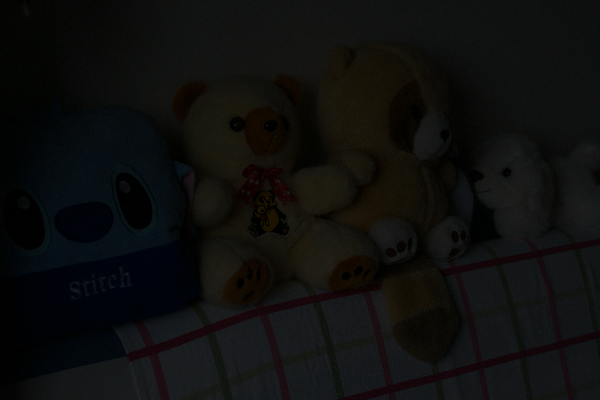

In [ ]:
cv2_imshow(img * 255)

In [ ]:
img.shape

(400, 600, 3)

In [ ]:
X_in = np.array([img])

In [ ]:
X_out = predict_model.predict(X_in)

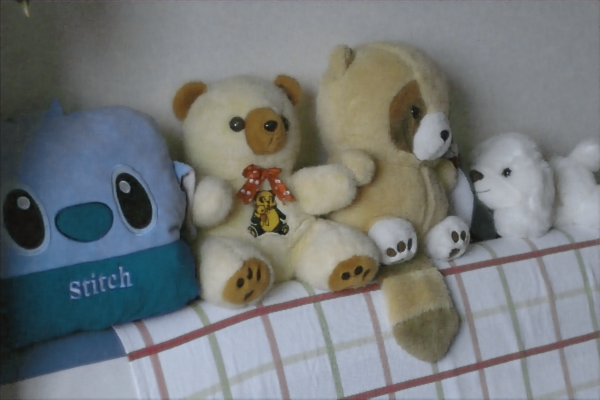

In [ ]:
cv2_imshow(X_out[0] * 255)

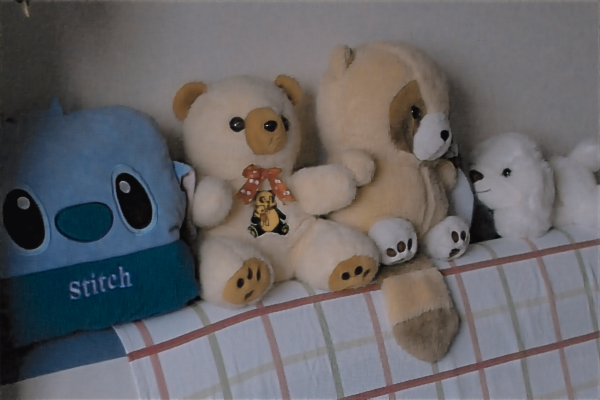

In [ ]:
cv2_imshow(X_out[0] * 255)

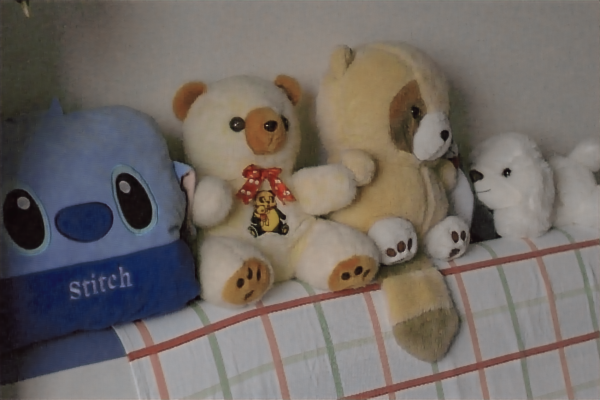

In [ ]:
cv2_imshow(X_out[0] * 255)

In [ ]:
cv2.imwrite('/content/drive/MyDrive/images/IMG 2/new.png', (X_out[0] * 255))

True